In [2]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_pyomo
import matplotlib.pyplot as plt

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

## `Toy dataset check`

In [3]:
def create_delayed_embeddings(x, tau, m):
    # Total length of the time series
    n = x.shape[0]
    
    # Initialize an empty list to store the embedding vectors
    embeddings = []
    
    # Loop over the time series to create each embedding vector
    # Only go up to points where a full embedding can be created
    for i in range(n - (m - 1) * tau):
        # Create the embedding vector by slicing the array
        embedding = jnp.array([x[i + j * tau] for j in range(m)])
        embeddings.append(embedding)
    
    # Convert list of embeddings to a Jax array
    return jnp.vstack(embeddings)

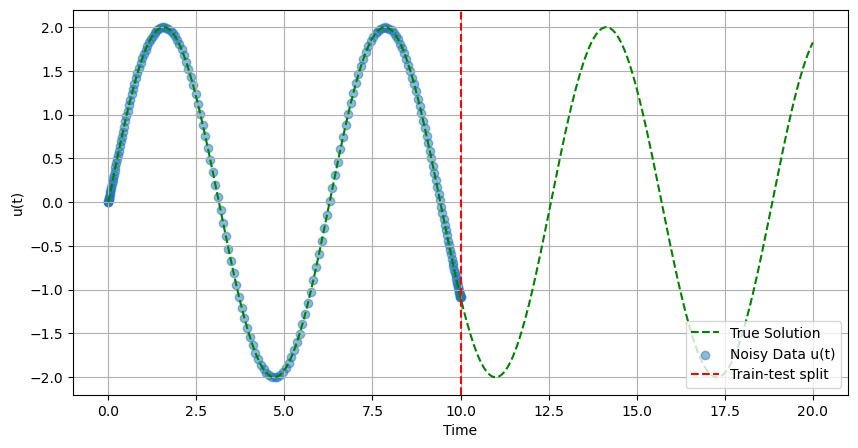

In [4]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.0
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [5]:
u = np.atleast_2d(y_noisy).T
r, c = u.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


In [6]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [7]:
n = 200
layer_widths = [1, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, "hessian_approximation": 'limited-memory', 
          'mu_strategy': 'adaptive', "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'
          }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[:n], t[:n], D[:n, :n], layer_widths, max_iter = 1000, act_func = "tanh", y_init = u_estimated, penalty_lambda = 0.01) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y


Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    51939
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    12261

Total number of variables............................:      261
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      261
                     variables with only upper bounds:        0
Total number of equality constraints...

Train MAE: 1.098635631602364
Test MAE: 1.2756662679527526


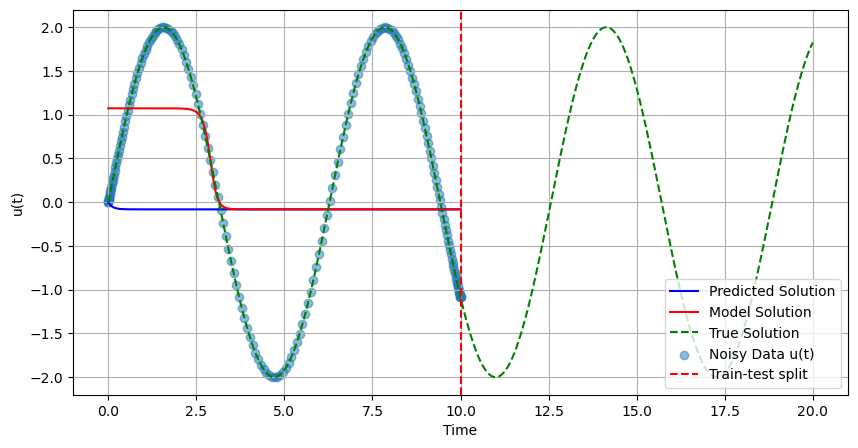

In [8]:
y_model = ode_model.extract_solution().T

def system_dynamics(y, t):
    input = jnp.array([y[0]])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print(f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
# plt.plot(t_test[N-1:], y_pred_test, 'b--', label='Predicted Solution', alpha = 0.5)

plt.plot(t[:n], np.squeeze(y_model), 'r', label='Model Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### If `t` is passed as a parameter

In [13]:
n = 200
layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, "hessian_approximation": 'limited-memory', 
          'mu_strategy': 'adaptive', "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'
          }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[:n], t[:n], D[:n, :n], layer_widths, max_iter = 1000, act_func = "tanh", y_init = u_estimated, penalty_lambda = 0.01, time_invariant=False) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    55919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16321

Total number of variables............................:      281
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      281
                     variables with only upper bounds:        0
Total number of equality constraints.

Train MAE: 0.04505121447437138
Test MAE: 11.324000661414786


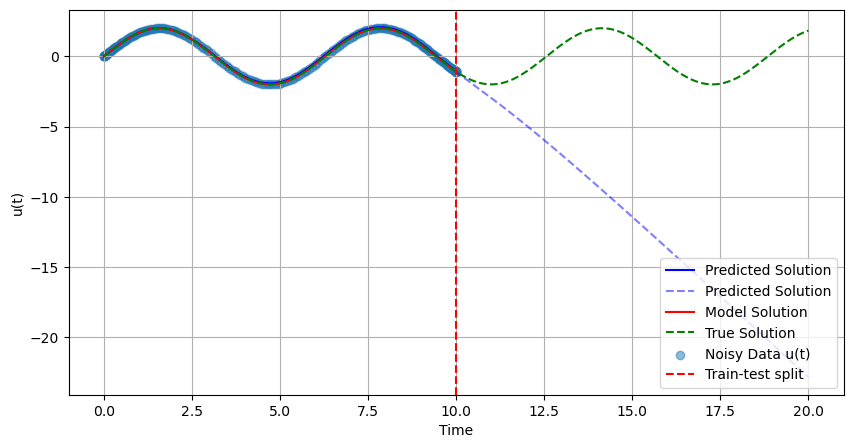

In [15]:
y_model = ode_model.extract_solution().T

def system_dynamics(y, t):
    input = jnp.array([y[0], t])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print(f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test[N-1:], y_pred_test, 'b--', label='Predicted Solution', alpha = 0.5)

plt.plot(t[:n], np.squeeze(y_model), 'r', label='Model Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Fails to predict beyond the train set

## 2D Example Working

In [9]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_ho_cheb = compute_weights(t_ho_cheb)
D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [10]:
layer_widths = [2, 10, 2]

params = {'tol': 1e-8, 'halt_on_ampl_error': 'yes'}
start_timer_build = time.time()
ode_model = NeuralODEPyomo(y_noisy_ho_cheb, t_ho_cheb, D_ho_cheb, layer_widths, max_iter = 1000, act_func = "tanh", w_init_method = 'xavier', params = params, y_init = estimated_solution_ho_cheb) # , y_init = estimated_solution_ho_cheb

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

y_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1]])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_neural_nets_1d_sin/neural_net_pyomo.py:68: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes
tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    96316
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20641

Total number of variables............................:      452
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      452
                     variables with only upper bounds:        0
Total number of equality cons

In [11]:
initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_ho_cheb)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_ho_cheb))
print (f"Train MAE: {mae_train}")


y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_ho_cheb[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_ho_cheb[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.020154443323591124
Test MAE: 0.023739105296246593


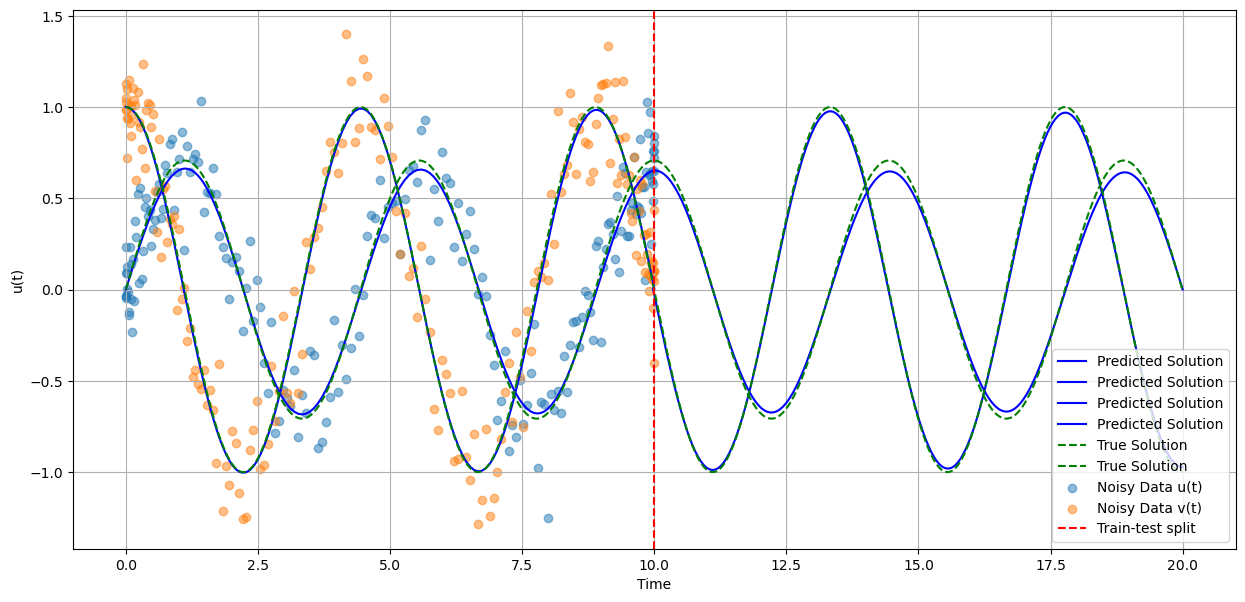

In [12]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho_cheb, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb[N-1:], y_pred_test, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb, y_test_ho_cheb, 'g--', label='True Solution')
plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()